In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

import time as time
import platform as platform

import h5py

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_cdv


In [7]:
from tools.misc_tools import create_CDV_data, compute_lyapunov_spectrum

In [8]:
# setting seed for PRNGs
prng_seed = 42
np.random.seed(prng_seed)

FTYPE = np.float64
ITYPE = np.int64

# Lorenz System

In [9]:
# setting up params (and saving, if applicable)
params_mat = np.array([
#     [0.85, -0.801*0.85, 0.1, 1.25, 0.2, 0.5],
#     [0.90, -0.801*0.90, 0.1, 1.25, 0.2, 0.5],
#     [0.93, -0.801*0.93, 0.1, 1.25, 0.2, 0.5],
    [0.95, -0.76095, 0.1, 1.25, 0.2, 0.5],
#     [0.97, -0.801*0.97, 0.1, 1.25, 0.2, 0.5],
    [0.99, -0.801*0.99, 0.1, 1.25, 0.2, 0.5],
])
print(params_mat)
num_cases = params_mat.shape[0]

t0 = 0.0
T = 2100.0
delta_t = 0.1

return_params_arr = False
normalize_flag = False
alldata_withparams_flag = True

init_state = np.array([0.9, 0.2, -0.1, -0.5, -0.2, 0.2], dtype=FTYPE)

[[ 0.95    -0.76095  0.1      1.25     0.2      0.5    ]
 [ 0.99    -0.79299  0.1      1.25     0.2      0.5    ]]


### Creating initial data, for transient inspection and cutoff

In [10]:
time_creation = time.time()
res_dict = create_CDV_data(
    T, t0, delta_t, 
    params_mat, init_state,
    return_params_arr=return_params_arr,
    normalize=normalize_flag,
    alldata_withparams=alldata_withparams_flag,
    FTYPE=FTYPE,
    ITYPE=ITYPE,
)
time_creation = time.time() - time_creation
print('time_creation : {:.0f} s'.format(time_creation))

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']
params_arr = res_dict['params_arr']
normalization_constant_arr = res_dict['normalization_constant_arr']

time_creation : 11 s


In [11]:
# making relevant helper arrays to cut off initial transient
initial_t0 = 2000
T -= initial_t0


initial_t0 = np.array(
    [initial_t0]*params_mat.shape[0], dtype=FTYPE) # try to keep all entries the same
initial_idx = np.zeros_like(initial_t0, dtype=ITYPE)

begin_idx = 0
len_relevant_idx = 0
for i in range(len(initial_t0)):
    init_idx = ITYPE( (initial_t0[i] + 0.5*delta_t)//delta_t )
    initial_idx[i] = init_idx + begin_idx
    len_relevant_idx += boundary_idx_arr[i] - initial_idx[i]
    begin_idx = boundary_idx_arr[i]

relevant_idx = np.empty(shape=len_relevant_idx, dtype=ITYPE)
start = 0
for i in range(len(initial_t0)):
    end = start + (boundary_idx_arr[i] - initial_idx[i])
    relevant_idx[start:end] = np.arange(initial_idx[i], boundary_idx_arr[i])
    start = end

In [12]:
print('boundary_idx_arr :', boundary_idx_arr)
print('initial_idx :', initial_idx)

boundary_idx_arr : [21001 42002]
initial_idx : [20000 41001]


In [13]:
# cutting off initial transient
all_data = all_data[relevant_idx]
# init_idx = 0
# for i in range(len(boundary_idx_arr)):
#     init_idx += (initial_t0[i] + 0.25*delta_t)//delta_t
#     boundary_idx_arr[i] -= init_idx

prev_boundary_idx = 0
for i in range(num_cases):
    boundary_idx_arr[i] = prev_boundary_idx + (boundary_idx_arr[i] - initial_idx[i])
    prev_boundary_idx = boundary_idx_arr[i]

In [14]:
boundary_idx_arr

array([1001, 2002])

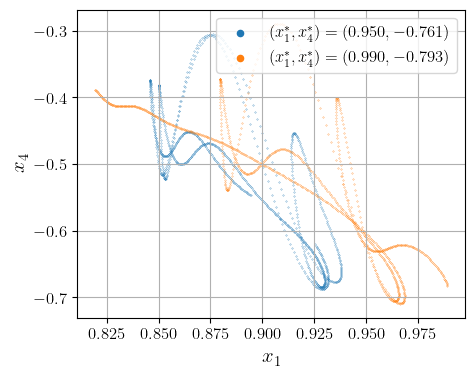

In [15]:
begin_idx = 0
for i in range(boundary_idx_arr.shape[0]):
    end_idx = boundary_idx_arr[i]
    plt.scatter(
        all_data[begin_idx:end_idx, 0],
        all_data[begin_idx:end_idx, 3],
        marker='.',
#         linestyle='',
#         markersize=1,
        s=0.2,
        label=r"$(x_1^*, x_4^*)  = ("+'{:.3f}, {:.3f}'.format(params_mat[i][0], params_mat[i][1])+')$',
    )
    begin_idx = end_idx

plt.grid(True)

plt.xlabel(r'$x_1$', fontsize=15)
plt.ylabel(r'$x_4$', fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(markerscale=20, fontsize=12)

plt.gcf().set_size_inches(5,4)

# plt.savefig(os.getcwd()+'/cdv_mutliparamplot_x1x4.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [16]:
new_data = all_data

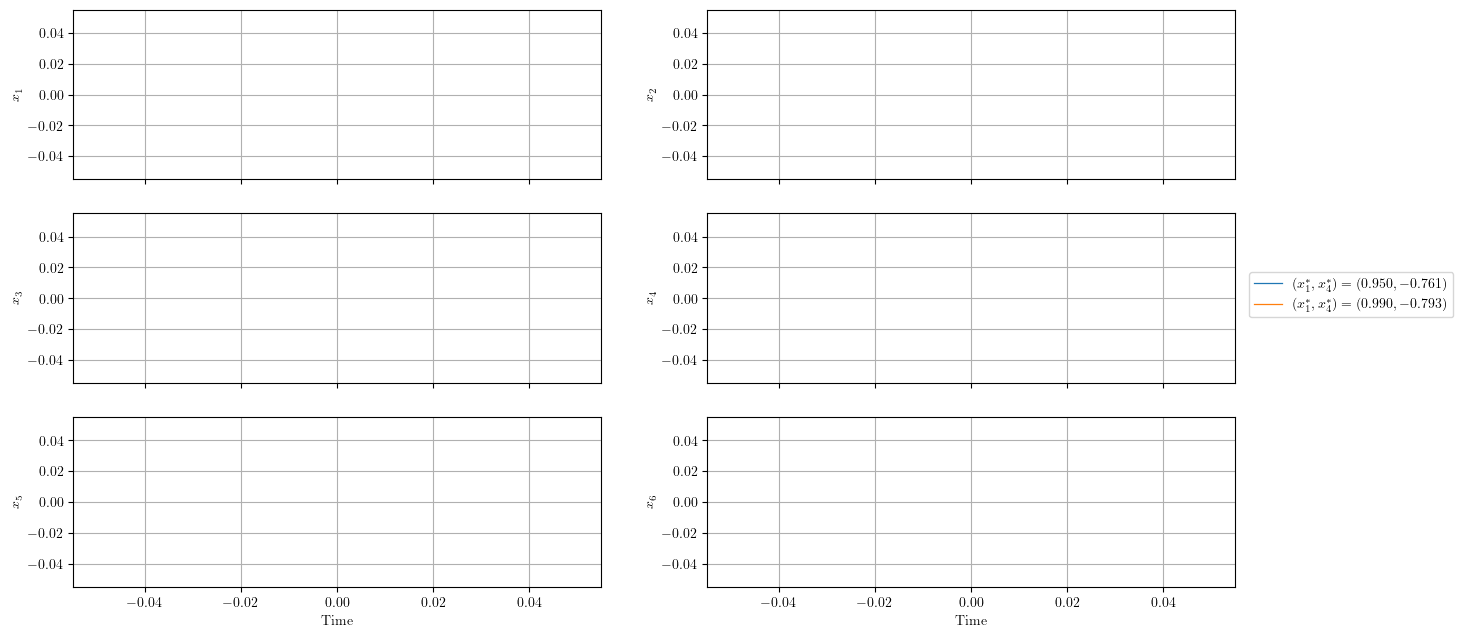

In [17]:
num_cols = 2
num_rows = int(6 / num_cols)

fig = plt.figure(figsize=(7.5*num_cols, 2.5*num_rows))

input_time = np.arange(0, boundary_idx_arr[0])*delta_t

subplot_idx = 1
for j in range(6):
    ax_orig = fig.add_subplot(num_rows, num_cols, subplot_idx)

    begin_idx = 0
    for i in range(boundary_idx_arr.shape[0]):
        end_idx = boundary_idx_arr[i]-30000
        input_time = np.arange(0, end_idx-begin_idx)*delta_t
        if j == 0:
            label_str = r"$(x_1^*, x_4^*)  = ("+'{:.3f}, {:.3f}'.format(params_mat[i][0], params_mat[i][1])+')$'
        else:
            label_str = '__nolabel__'
        ax_orig.plot(
            input_time,
            all_data[begin_idx:end_idx, j],
            linewidth=0.9, 
            label=label_str,
        )
        begin_idx = boundary_idx_arr[i]
    ax_orig.set_ylabel(r'$x_'+str(j+1)+'$')
    ax_orig.grid(True)
    ax_orig.set_axisbelow(True)
#         for jj in range(blocked_time.shape[0]):
#             plt_obj = ax_orig.axvspan(xmin=blocked_time[jj, 0], xmax=blocked_time[jj, 1], color='C2', alpha=0.3)
    subplot_idx += 1
    if j < 6-1 and j!=6-2:
        ax_orig.xaxis.set_ticklabels([])
#     if j == 3:
#         ax_orig.legend([plt_obj], ['Blocked\nFlow'], loc='upper left', bbox_to_anchor=[1, 0.7])
#         plt.legend([plt_obj], [r'Blocked Flow Region'])
    if j == 6-2:
        ax_orig.set_xlabel('Time')

ax_orig.set_xlabel('Time')

fig.legend(loc='center right', bbox_to_anchor=[1.05, 0.5])

# plt.savefig(os.getcwd()+'/cdv_mutliparamplot_all.pdf', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

### Saving the data

In [18]:
# making ae save directory
dir_name_data = os.getcwd() + dir_sep + 'saved_data'
if not os.path.isdir(dir_name_data):
    os.makedirs(dir_name_data)

counter = 0
while True:
    dir_check = 'data_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_data + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_data = dir_name_data + dir_sep + dir_check
os.makedirs(dir_name_data)
print('dir_name_data:', dir_name_data)


# saving sim data
sim_data = {
    'params_mat':params_mat,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'return_params_arr':return_params_arr,
    'normalize_flag':normalize_flag,
    'alldata_withparams_flag':alldata_withparams_flag,
    'prng_seed':prng_seed,
}
with open(dir_name_data+dir_sep+'sim_data_params.txt', 'w') as f:
    f.write(str(sim_data))

dir_name_data: /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_data/data_006


In [19]:
# saving the data
np.savez(
    dir_name_data+dir_sep+'data',
    all_data=all_data,
    boundary_idx_arr=boundary_idx_arr,
    normalization_constant_arr=[normalization_constant_arr],
    initial_t0=initial_t0,
    init_state_org=init_state,
    # init_state_mat=init_state_mat,
    # lyapunov_spectrum_mat=lpspectrum_mat,
    )

### Computing the Lyapunov spectrum

In [20]:
cdf_kwargs = {
    'T':11000,
    't0':0,
    'delta_t':delta_t,
    'return_params_arr':False,
    'normalize':False,
    'alldata_withparams':False,
    'FTYPE':np.float64,
    'ITYPE':np.int64
}

create_data_fn = create_CDV_data
num_modes = 6

init_state_mat = np.empty(shape=(num_cases, num_modes), dtype=FTYPE)
begin_idx = 0
for i in range(num_cases):
    init_state_mat[i, :] = all_data[begin_idx, 0:num_modes]
    begin_idx = boundary_idx_arr[i]

dy = 1e-9
dy_mat = np.empty(shape=num_cases, dtype=FTYPE)
begin_idx = 0
for i in range(num_cases):
    # dy_mat[i] = dy * np.mean(  np.linalg.norm( all_data[begin_idx:boundary_idx_arr[i]], axis=1 )/xgrid.shape[0]  ) timeMean of spaceMeanofSpaceNorm
    # dy_mat[i] = dy * np.mean( np.linalg.norm( all_data[begin_idx:boundary_idx_arr[i], 0:num_modes], axis=0 )/( (boundary_idx_arr[i]-begin_idx)**0.5 ) ) # spaceMean of timeRMS
    dy_mat[i] = np.mean( np.mean(all_data[begin_idx:boundary_idx_arr[i], 0:num_modes]**2, axis=0)**0.5 )
    # print(dy_mat[i])
    dy_mat[i] *= dy
    begin_idx = boundary_idx_arr[i]
    print('dy_mat[{}] :'.format(i), dy_mat[i])
print('')

# cleaning up
del(all_data)
del(boundary_idx_arr)
del(params_arr)
del(normalization_constant_arr)
del(relevant_idx)
del(res_dict)

lpspectrum_mat, _ = compute_lyapunov_spectrum(
    create_data_fn, cdf_kwargs, num_modes, 
    init_state_mat, params_mat, dy_mat,
    zeta=10, delta_completionratio=0.1, num_exp=None, print_flag=True, num_init_ignore=1000)

dy_mat[0] : 3.724937170372788e-10
dy_mat[1] : 3.797870391548029e-10

number of evaluation intervals per case: 11000

case 1 completion_ratio : 0.1, elapsed_time : 20.513s, global_completion : 5.0%
case 1 completion_ratio : 0.2, elapsed_time : 39.874s, global_completion : 10.0%
case 1 completion_ratio : 0.3, elapsed_time : 60.575s, global_completion : 15.0%
case 1 completion_ratio : 0.4, elapsed_time : 80.314s, global_completion : 20.0%
case 1 completion_ratio : 0.5, elapsed_time : 100.851s, global_completion : 25.0%
case 1 completion_ratio : 0.6, elapsed_time : 120.62s, global_completion : 30.0%
case 1 completion_ratio : 0.7, elapsed_time : 140.334s, global_completion : 35.0%
case 1 completion_ratio : 0.8, elapsed_time : 159.922s, global_completion : 40.0%
case 1 completion_ratio : 0.9, elapsed_time : 179.471s, global_completion : 45.0%
case 1 completion_ratio : 1.0, elapsed_time : 198.816s, global_completion : 50.0%
case 1 MLE : 0.02696

case 2 completion_ratio : 0.1, elapsed_time : 2

In [21]:
lpspectrum_mat.sort(axis=1)
lpspectrum_mat = lpspectrum_mat[:, -1::-1]

In [22]:
print(lpspectrum_mat[:, 0])
print(lpspectrum_mat[:, 0]**(-1))

[0.02696048 0.00019373]
[  37.09133146 5161.81053038]


In [23]:
def find_DKY(lp_spectrum):
    # lp_spectrum is sorted largest to smallest
    running_sum = np.empty_like(lp_spectrum)
    running_sum[:] = lp_spectrum
    for i in range(1, lp_spectrum.shape[0]):
        running_sum[i] += running_sum[i-1]
    idx = np.where(running_sum >= 0)[0]
    idx.sort()
    idx = idx[-1]
    DKY = (idx+1) + running_sum[idx]/np.abs(lp_spectrum[idx+1])
    return DKY

In [24]:
DKY_lst = []
for i in range(lpspectrum_mat.shape[0]):
    DKY = find_DKY(lpspectrum_mat[i])
    print(DKY, lpspectrum_mat[i])
    DKY_lst.append(DKY)

2.3160196082548294 [ 0.02696048 -0.00200994 -0.07895251 -0.10167068 -0.22003766 -0.22428963]
1.0835562475195233 [ 1.93730474e-04 -2.31856360e-03 -5.19349882e-02 -1.02855695e-01
 -2.16972599e-01 -2.26111804e-01]


### Computing new data based on 'initial states' from the transient cutoffs and total time from mean Lyapunov time

In [25]:
with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = np.array(fl['all_data'])
    boundary_idx_arr = np.array(fl['boundary_idx_arr'])
    normalization_constant_arr = np.array(fl['normalization_constant_arr'])
    initial_t0 = np.array(fl['initial_t0'])
    init_state_org = np.array(fl['init_state_org'])

In [26]:
# saving the data
np.savez(
    dir_name_data+dir_sep+'data',
    all_data=all_data,
    boundary_idx_arr=boundary_idx_arr,
    normalization_constant_arr=normalization_constant_arr,
    initial_t0=initial_t0,
    init_state_org=init_state_org,
    init_state_mat=init_state_mat,
    lyapunov_spectrum_mat=lpspectrum_mat,
    DKY_lst=np.array(DKY_lst)
)

In [30]:
lp_dict = {
    'lp_exp':[list(elem) for elem in lpspectrum_mat],
    'DKY_lst':list(DKY_lst),
    'lyap_time':list(lpspectrum_mat[:, 0]**(-1))
}
with open(dir_name_data+dir_sep+'lp_exp.txt', 'w') as f:
    f.write(str(lp_dict))

In [28]:
# fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)

In [29]:
# fl.files